In [1]:
# Let's load some other packages we need
import os
import pandas as pd
import random

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

import models
from models import InvertibleNN,Parellel_Renorm_Dynamic
from models import normalize_3d,train_and_memorize,read_and_visulize
#from models import Parellel_Renorm_Dynamic
from EI_calculation import approx_ei
from tqdm import tqdm

from sklearn.neighbors import KernelDensity

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

from nilearn import datasets



#Whether to use cuda or not
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
#device =torch.device('cpu')

ModuleNotFoundError: No module named 'models'

In [2]:
#Since we can can how many number of of ROIs we want to investigate in a large range
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=100)
atlas_filename = dataset.maps
labels = dataset.labels
#indices=dataset.indices
description=dataset.description

In [3]:
#To find out indexes for the corresponding system
indexes=[]
for label in labels:
    if b'Vis' in label:
        indexes.append(0)
    elif b'SomMot' in label:
        indexes.append(1)
    elif b'DorsAttn' in label:
        indexes.append(2)
    elif b'SalVentAttn' in label:
        indexes.append(3)
    elif b'Limbic' in label:
        indexes.append(4)
    elif b'Cont' in label:
        indexes.append(5)
    elif b'Default' in label:
        indexes.append(6)
indexes=np.array(indexes)

In [4]:
#
torch.cuda.empty_cache()
#f_imgs=np.load('Preprocessed_files/AOMIC_preprocessed_schaefer_100.npy',allow_pickle=True)
f_imgs=np.load('Preprocessed_files/AOMIC_preprocessed_aal.npy',allow_pickle=True)
f_imgs_norm=f_imgs
#f_imgs_norm[:,:,indexes!=0]=0
#f_imgs_norm[:,:,np.max(np.abs(f_imgs_norm),axis=(0,1))>10.23]=0
#f_imgs_norm=f_imgs_norm[:,:,np.logical_and(indexes!=0,np.max(np.abs(f_imgs_norm),axis=(0,1))<11.2)]
#normalize 3d
f_imgs_norm=normalize_3d(f_imgs_norm)   
f_imgs_norm=torch.tensor(f_imgs_norm,device=device).to(torch.float32)   

In [5]:
#The macro element
#macro=torch.zeros([f_imgs_norm.shape[0],f_imgs_norm.shape[1],1],device=device).to(torch.float32)  

In [6]:
#Take the net encoding function
#Only pick up the visual system
#f_imgs_norm=f_imgs_norm[:,:,indexes==0]
#f_imgs_norm=torch.cat((f_imgs_norm,macro),axis=2) 
#decide the train and test data
f_imgs_norm_train=f_imgs_norm[:-30,:,:]
f_imgs_norm_test=f_imgs_norm[-30:,:,:]

In [7]:
f_imgs_norm_train.shape

torch.Size([800, 290, 116])

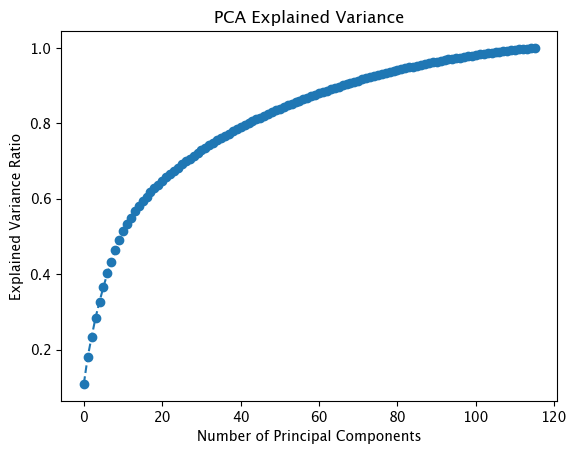

In [8]:
# 进行 PCA 分析
scaler = StandardScaler()
scaler.fit(f_imgs_norm_train.reshape(-1,f_imgs_norm_train.shape[-1]))
f_imgs_zscore=scaler.transform(f_imgs_norm_train.reshape(-1,f_imgs_norm_train.shape[-1]))
pca = PCA(n_components=None)
pca.fit(f_imgs_zscore)

# 获取 explained_variance
explained_variance = pca.explained_variance_ratio_
explained_variance = explained_variance.cumsum()

# 绘制 explained_variance 图
plt.figure()
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

  0%|          | 0/10001 [00:00<?, ?it/s]

iter 0: loss = 0.10406668
iter 0: loss = 0.06836304
iter 0: forward loss =  [0.041078537702560425, 0.041256383061409, 0.04152802750468254, 0.04201819747686386, 0.04288557916879654, 0.044385138899087906, 0.04599679261445999]
iter 0: backward loss =  [0.054569002240896225, 0.05192432180047035, 0.05337950587272644, 0.053252462297677994, 0.0544629730284214, 0.11243768036365509, 0.04929223284125328]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.1910917972033347, 0.008069021001630079, 0.24873500189062087, 0.4878215060475509, 0.2972426913151767, 0.0, 0.08891671073754048]
sigmas kde= [tensor(0.1450, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2161, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2162, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1516, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2720, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(1.0665, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2428, dtype=torch.float64, grad

  2%|▏         | 201/10001 [08:57<95:36:53, 35.12s/it]

iter 200: loss = 0.09844778
iter 200: loss = 0.06637668
iter 200: forward loss =  [0.043343592435121536, 0.04386131092905998, 0.044066205620765686, 0.04452250152826309, 0.0454738587141037, 0.046577513217926025, 0.04865935817360878]
iter 200: backward loss =  [0.04606616869568825, 0.0531490258872509, 0.0544227659702301, 0.054681479930877686, 0.05524878203868866, 0.059026747941970825, 0.050035204738378525]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.35179230518598287, 0.11502086025008738, 0.31681499117288986, 0.5437385360969612, 0.36587003425056075, 0.0, 0.035030077077041644]
sigmas kde= [tensor(0.1021, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1760, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1836, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1376, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2462, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.9198, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2797, dtype=torch.f

  4%|▍         | 401/10001 [15:54<75:58:31, 28.49s/it]

iter 400: loss = 0.09495171
iter 400: loss = 0.06441727
iter 400: forward loss =  [0.04206470400094986, 0.042591314762830734, 0.042968928813934326, 0.04342547059059143, 0.04441022127866745, 0.04599110409617424, 0.04711373150348663]
iter 400: backward loss =  [0.044705118983983994, 0.05077870935201645, 0.051746148616075516, 0.05234178155660629, 0.05210547149181366, 0.054403338581323624, 0.050016023218631744]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.38553018492878277, 0.15406566162925825, 0.3459820148584009, 0.5863584000993856, 0.390619443953076, 0.0, 0.0]
sigmas kde= [tensor(0.0973, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1647, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1758, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1288, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2285, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6853, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2986, dtype=torch.float64, grad_fn=<

  6%|▌         | 601/10001 [20:47<43:04:35, 16.50s/it]

iter 600: loss = 0.09892981
iter 600: loss = 0.06557367
iter 600: forward loss =  [0.04292261227965355, 0.04293210431933403, 0.04321761056780815, 0.043555233627557755, 0.04454301670193672, 0.04631171002984047, 0.0479842871427536]
iter 600: backward loss =  [0.045302119106054306, 0.052559297531843185, 0.053644802421331406, 0.05398619920015335, 0.05392550677061081, 0.07040537893772125, 0.051218803972005844]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.39474987974179165, 0.14789343786397582, 0.3352584168471981, 0.5664069444784772, 0.38469277124947243, 0.0, 0.11448508093595533]
sigmas kde= [tensor(0.0963, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1644, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1741, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1316, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2258, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6669, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2376, dtype=torch.fl

  8%|▊         | 801/10001 [26:08<58:57:25, 23.07s/it]

iter 800: loss = 0.09530194
iter 800: loss = 0.06460117
iter 800: forward loss =  [0.04233765974640846, 0.04260386899113655, 0.04295860975980759, 0.04340006411075592, 0.04418249800801277, 0.04545113444328308, 0.04693678766489029]
iter 800: backward loss =  [0.04452700912952423, 0.05213918164372444, 0.05288384109735489, 0.052854228764772415, 0.052749861031770706, 0.054403580725193024, 0.04968533664941788]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.37648007681699075, 0.14757924294436683, 0.3531323081713288, 0.5695326253754794, 0.4189707192483722, 0.0, 0.0830910923651248]
sigmas kde= [tensor(0.1011, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1657, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1728, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1300, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2250, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6379, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2460, dtype=torch.float

 10%|▉         | 1000/10001 [29:58<2:38:05,  1.05s/it]

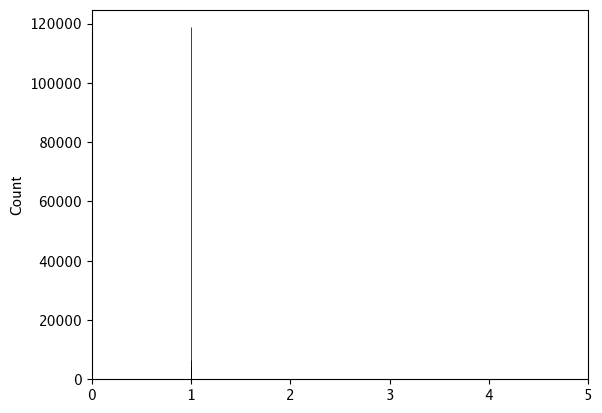

iter 1000: loss = 0.09290882
iter 1000: loss = 0.06308378
iter 1000: forward loss =  [0.04137391069602307, 0.04161055013537407, 0.04158974438905716, 0.04208654910326004, 0.04313092306256294, 0.04460277780890465, 0.04569924622774124]
iter 1000: backward loss =  [0.04341973425610478, 0.050874918699264526, 0.05178180709481239, 0.051051292568445206, 0.05108841508626938, 0.053741440176963806, 0.048310451209545135]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.38159725387903937, 0.18145460692716608, 0.3698185266477447, 0.5963885059025543, 0.44240674172738487, 0.0, 0.14182212888749446]
sigmas kde= [tensor(0.1003, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1558, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1691, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1251, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2189, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6669, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2273, dtype=torc

 12%|█▏        | 1201/10001 [45:39<40:22:13, 16.52s/it]  

iter 1200: loss = 0.09493490
iter 1200: loss = 0.06289587
iter 1200: forward loss =  [0.04134583641251565, 0.04182331636548042, 0.04227771982550621, 0.04267154261469841, 0.04391249641776085, 0.04550470784306526, 0.046728942543268204]
iter 1200: backward loss =  [0.043100073742057245, 0.05151200294494629, 0.05338113754987717, 0.05314503237605095, 0.053406696766614914, 0.056213848292827606, 0.04952094703912735]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.39458693248097704, 0.17407924772385225, 0.3690803669349234, 0.5916692414208667, 0.4245522524086347, 0.0, 0.11688556539502415]
sigmas kde= [tensor(0.0976, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1579, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1704, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1271, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2212, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6450, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2334, dtype=torch

 14%|█▍        | 1401/10001 [50:01<39:04:28, 16.36s/it]

iter 1400: loss = 0.09727297
iter 1400: loss = 0.06307248
iter 1400: forward loss =  [0.04163257053102654, 0.042124588042497635, 0.04239919036626816, 0.04303000122308731, 0.043794117867946625, 0.04561985284090042, 0.04683656990528107]
iter 1400: backward loss =  [0.04287981803131137, 0.05080745741724968, 0.05249875411391258, 0.05247198045253754, 0.05276069417595863, 0.07465462386608124, 0.049400538206100464]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.40088260467936093, 0.18032788197437993, 0.36765082829466444, 0.5872763603647283, 0.43290462589754725, 0.0, 0.15541060457887867]
sigmas kde= [tensor(0.0973, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1557, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1679, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1258, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2203, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6232, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2212, dtype=torc

 16%|█▌        | 1601/10001 [54:21<38:39:43, 16.57s/it]

iter 1600: loss = 0.09714559
iter 1600: loss = 0.06398438
iter 1600: forward loss =  [0.041895079139064394, 0.042098723351955414, 0.04224233329296112, 0.04295208677649498, 0.04414195194840431, 0.04606829583644867, 0.04802659526467323]
iter 1600: backward loss =  [0.044178608274837695, 0.052399348467588425, 0.05341200903058052, 0.05420616269111633, 0.05388195067644119, 0.06453671306371689, 0.049979258328676224]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.41518920503165374, 0.18854026100140148, 0.3637041985773091, 0.5923274744879825, 0.4446820215471397, 0.0, 0.1755688953879131]
sigmas kde= [tensor(0.0943, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1545, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1693, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1252, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2062, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.7486, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2216, dtype=torch

 18%|█▊        | 1801/10001 [58:43<36:51:50, 16.18s/it]

iter 1800: loss = 0.09709659
iter 1800: loss = 0.06478163
iter 1800: forward loss =  [0.04305236580225896, 0.04317908734083176, 0.04316362738609314, 0.04367704316973686, 0.04445287585258484, 0.04609595984220505, 0.04729108512401581]
iter 1800: backward loss =  [0.04345853685347155, 0.052797831594944, 0.05404362827539444, 0.0532570406794548, 0.05399664491415024, 0.06174217909574509, 0.049468204379081726]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4209005549558312, 0.19682397213437988, 0.3821430588742362, 0.6001258132142625, 0.4049615184089485, 0.0, 0.0]
sigmas kde= [tensor(0.0942, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1519, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1689, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1252, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2272, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6794, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.3276, dtype=torch.float64, grad_fn=<Mean

 20%|█▉        | 2000/10001 [1:02:13<2:22:49,  1.07s/it]

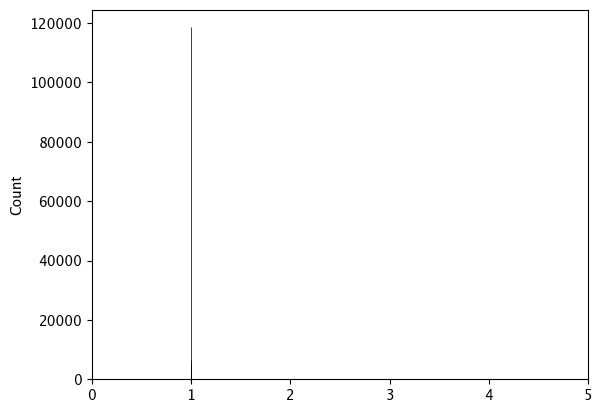

iter 2000: loss = 0.09671868
iter 2000: loss = 0.06418071
iter 2000: forward loss =  [0.04234048846411958, 0.04319951683282852, 0.04350758716464043, 0.04394591599702835, 0.04512764886021614, 0.046897802501916885, 0.04830462113022804]
iter 2000: backward loss =  [0.043680452865012195, 0.052438680082559586, 0.05267861858010292, 0.05371250584721565, 0.05379551276564598, 0.05789361521601677, 0.04950781911611557]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4043358786270268, 0.19437492173970275, 0.3786673119199463, 0.6073905894833626, 0.4372848337720023, 0.0, 0.1466876936191721]
sigmas kde= [tensor(0.0977, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1515, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1648, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1240, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2102, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.7273, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2232, dtype=torch.fl

 22%|██▏       | 2201/10001 [1:17:09<35:56:23, 16.59s/it]  

iter 2200: loss = 0.09906878
iter 2200: loss = 0.06562860
iter 2200: forward loss =  [0.04401116285033863, 0.04442479461431503, 0.044474806636571884, 0.045014381408691406, 0.04591256380081177, 0.04763273149728775, 0.04917164146900177]
iter 2200: backward loss =  [0.04323487885976647, 0.05296361446380615, 0.05303798243403435, 0.0536651574075222, 0.05247018113732338, 0.06907794624567032, 0.04838964343070984]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4182096704732646, 0.20942358191251204, 0.3921158688936642, 0.6114420055858893, 0.4662383073023212, 0.0, 0.0]
sigmas kde= [tensor(0.0944, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1479, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1638, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1215, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1998, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5639, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.3194, dtype=torch.float64, grad_fn=<M

 24%|██▍       | 2401/10001 [1:21:31<35:19:37, 16.73s/it]

iter 2400: loss = 0.09977456
iter 2400: loss = 0.06498199
iter 2400: forward loss =  [0.0431955101176385, 0.04365704208612442, 0.04402659833431244, 0.04468267410993576, 0.04575807601213455, 0.04810228943824768, 0.04914332553744316]
iter 2400: backward loss =  [0.043572951386302634, 0.052976563572883606, 0.05377752333879471, 0.0534672774374485, 0.053316596895456314, 0.07204072922468185, 0.05070476606488228]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4113768466962738, 0.19968091562382909, 0.38711029754656384, 0.6037876628699639, 0.4254608358949549, 0.0, 0.07241434624540766]
sigmas kde= [tensor(0.0960, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1508, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1658, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1234, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2136, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6217, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2710, dtype=torch.fl

 26%|██▌       | 2601/10001 [1:25:55<33:42:26, 16.40s/it]

iter 2600: loss = 0.10064412
iter 2600: loss = 0.06451642
iter 2600: forward loss =  [0.042892514962139715, 0.04395093768835068, 0.044103141874074936, 0.044474296271800995, 0.04537836089730263, 0.04688488319516182, 0.04846048355102539]
iter 2600: backward loss =  [0.04324781913416593, 0.052523478865623474, 0.053517501801252365, 0.05365423113107681, 0.05250577628612518, 0.08297814428806305, 0.04993728548288345]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4192532139455481, 0.19884954663733417, 0.37781196093094016, 0.6006241440740329, 0.4450402734820945, 0.0, 0.17953262420540494]
sigmas kde= [tensor(0.0941, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1501, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1666, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1239, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2117, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6581, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2059, dtype=torc

 28%|██▊       | 2801/10001 [1:30:16<32:12:58, 16.11s/it]

iter 2800: loss = 0.09603250
iter 2800: loss = 0.06441462
iter 2800: forward loss =  [0.04276369154925086, 0.04327910766005516, 0.04355670511722565, 0.04387395828962326, 0.044715043157339096, 0.04571733623743057, 0.047121867537498474]
iter 2800: backward loss =  [0.043301846998348326, 0.051991455256938934, 0.051978155970573425, 0.05172929912805557, 0.053636107593774796, 0.05975024402141571, 0.04881270229816437]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.40805934551941586, 0.18746975632349008, 0.3728651269303184, 0.6042715820995977, 0.4373129463923841, 0.0, 0.15586690220889765]
sigmas kde= [tensor(0.0964, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1540, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1698, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1242, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2198, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6057, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2215, dtype=tor

 30%|██▉       | 3000/10001 [1:33:47<1:58:29,  1.02s/it] 

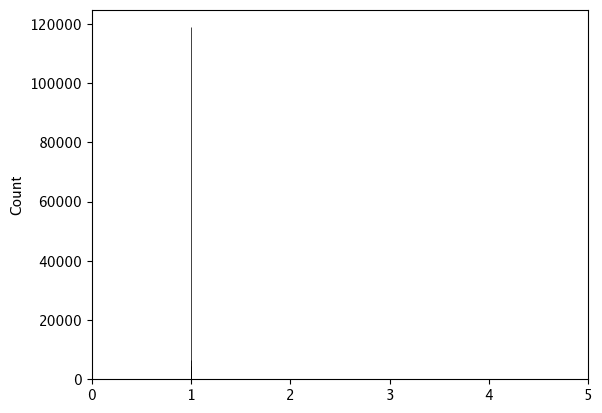

iter 3000: loss = 0.09895853
iter 3000: loss = 0.06294322
iter 3000: forward loss =  [0.0418219258030705, 0.042747169733047485, 0.042972829192876816, 0.04352128505706787, 0.04462559521198273, 0.04641621932387352, 0.04778166115283966]
iter 3000: backward loss =  [0.042242589595591316, 0.05182748660445213, 0.05182550847530365, 0.05164347216486931, 0.051836177706718445, 0.08427776396274567, 0.04917003586888313]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.43182759929180026, 0.20381442969331626, 0.38226480731683554, 0.6101086498836646, 0.454799792888594, 0.0, 0.03229769124766968]
sigmas kde= [tensor(0.0920, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1488, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1650, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1233, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2047, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6367, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2725, dtype=torch.

 32%|███▏      | 3201/10001 [1:48:44<30:48:15, 16.31s/it]  

iter 3200: loss = 0.10018787
iter 3200: loss = 0.06558144
iter 3200: forward loss =  [0.0435043779394864, 0.043977562338113785, 0.044204231351614, 0.04470711201429367, 0.04561089724302292, 0.04680224880576134, 0.04800671339035034]
iter 3200: backward loss =  [0.04415413205834603, 0.05298978090286255, 0.05402534827589989, 0.05318495258688927, 0.052855994552373886, 0.07753672450780869, 0.0497550331056118]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.41182351404673484, 0.20565930592509563, 0.3845075181594997, 0.6075489520454921, 0.4509035907245285, 0.0, 0.11446442858331729]
sigmas kde= [tensor(0.0965, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1484, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1651, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1235, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2195, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6551, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2392, dtype=torch.float

 34%|███▍      | 3401/10001 [1:53:05<29:57:52, 16.34s/it]

iter 3400: loss = 0.09739056
iter 3400: loss = 0.06471037
iter 3400: forward loss =  [0.04240818147864935, 0.043671537190675735, 0.04369819536805153, 0.04431236907839775, 0.04501023888587952, 0.04617231339216232, 0.047780461609363556]
iter 3400: backward loss =  [0.04460437861832016, 0.05405677482485771, 0.0537889301776886, 0.05344266816973686, 0.05340305343270302, 0.05879920721054077, 0.05058562010526657]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.42740741088357503, 0.19345339843257858, 0.37389590695867453, 0.5978041191571793, 0.4205963460495957, 0.0, 0.04398777368734441]
sigmas kde= [tensor(0.0923, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1526, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1678, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1244, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2214, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6394, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2724, dtype=torch.f

 36%|███▌      | 3601/10001 [1:58:49<36:06:11, 20.31s/it]

iter 3600: loss = 0.09711277
iter 3600: loss = 0.06655124
iter 3600: forward loss =  [0.04417530335689016, 0.04455776512622833, 0.04475076124072075, 0.04509912058711052, 0.045954201370477676, 0.04746490344405174, 0.048479750752449036]
iter 3600: backward loss =  [0.044751867396284506, 0.05307206138968468, 0.053006574511528015, 0.05269649252295494, 0.0528670996427536, 0.054217614233493805, 0.0486958883702755]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4177068302469268, 0.197803774435375, 0.37684276455136845, 0.6071002363453053, 0.43521010974571717, 0.0, 0.0]
sigmas kde= [tensor(0.0952, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1515, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1898, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1237, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2124, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5389, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.3247, dtype=torch.float64, grad_fn=

 38%|███▊      | 3801/10001 [2:04:13<35:08:04, 20.40s/it]

iter 3800: loss = 0.09706188
iter 3800: loss = 0.06414399
iter 3800: forward loss =  [0.04285668271791239, 0.04329454153776169, 0.04360295459628105, 0.04415418952703476, 0.04493698477745056, 0.04675782471895218, 0.04786626994609833]
iter 3800: backward loss =  [0.04257461679431141, 0.053822215646505356, 0.054086118936538696, 0.05386490374803543, 0.0538591630756855, 0.05853545665740967, 0.049221221357584]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4290146414089051, 0.20752375303630385, 0.3854990170942424, 0.5997165962993886, 0.46535519441183276, 0.0, 0.19557887432848253]
sigmas kde= [tensor(0.0937, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1491, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1653, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1225, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2048, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5895, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2066, dtype=torch.floa

 40%|███▉      | 4000/10001 [2:08:26<1:51:10,  1.11s/it] 

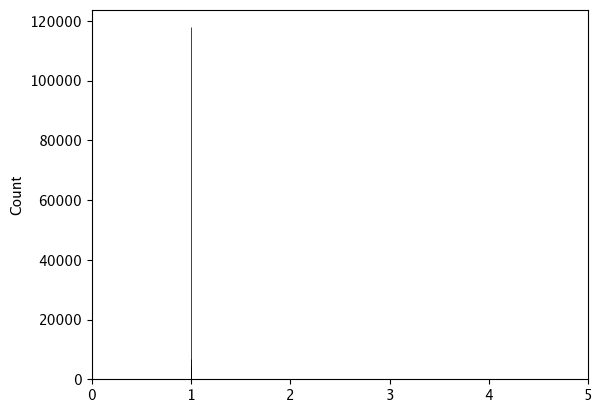

iter 4000: loss = 0.09714747
iter 4000: loss = 0.06238223
iter 4000: forward loss =  [0.04148287356406462, 0.042073436081409454, 0.04241041839122772, 0.04288160800933838, 0.043808504939079285, 0.04507439583539963, 0.0463988371193409]
iter 4000: backward loss =  [0.04179872095916806, 0.051650699228048325, 0.05294378846883774, 0.05317908525466919, 0.052617959678173065, 0.07541381567716599, 0.04829816147685051]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4245774764457003, 0.20177213086666182, 0.3927643280942327, 0.6207340910235554, 0.4721508450634098, 0.0, 0.07950488360608454]
sigmas kde= [tensor(0.0938, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1502, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1656, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1192, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2037, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5921, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2398, dtype=torch.f

 42%|████▏     | 4201/10001 [2:26:49<32:13:55, 20.01s/it]  

iter 4200: loss = 0.09829730
iter 4200: loss = 0.06485153
iter 4200: forward loss =  [0.04314578071029623, 0.04403219744563103, 0.044424545019865036, 0.04482336714863777, 0.04573697969317436, 0.04752069339156151, 0.04921523481607437]
iter 4200: backward loss =  [0.04341149627504788, 0.053159307688474655, 0.054256659001111984, 0.053523290902376175, 0.05459678918123245, 0.05977332964539528, 0.050461456179618835]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.42820920765684767, 0.20067593225596977, 0.37615924044428156, 0.6030814189129476, 0.4417647183802685, 0.0, 0.0]
sigmas kde= [tensor(0.0926, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1512, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1660, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1240, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2145, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6156, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.3598, dtype=torch.float64, grad

 44%|████▍     | 4401/10001 [2:32:25<38:52:12, 24.99s/it]

iter 4400: loss = 0.09801244
iter 4400: loss = 0.06492236
iter 4400: forward loss =  [0.0431678634416882, 0.04345070570707321, 0.04348207265138626, 0.0440136156976223, 0.04532724991440773, 0.047469403594732285, 0.048765480518341064]
iter 4400: backward loss =  [0.043508990543539156, 0.052699312567710876, 0.053198814392089844, 0.052844975143671036, 0.053446393460035324, 0.0643296018242836, 0.050382573157548904]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.41666272407660626, 0.20567608580038582, 0.3831888645036186, 0.6117230697032913, 0.462978394054583, 0.0, 0.18338563163415922]
sigmas kde= [tensor(0.0958, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1493, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1634, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1228, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2024, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.7490, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2061, dtype=torch

 46%|████▌     | 4601/10001 [2:38:13<32:22:34, 21.58s/it]

iter 4600: loss = 0.09803715
iter 4600: loss = 0.06394884
iter 4600: forward loss =  [0.04251131365369214, 0.04346984252333641, 0.04366971179842949, 0.04393484443426132, 0.04512448608875275, 0.046468719840049744, 0.04768044129014015]
iter 4600: backward loss =  [0.04287506007054941, 0.052303239703178406, 0.05270545557141304, 0.052795231342315674, 0.05222970247268677, 0.07146846503019333, 0.049023501574993134]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4337040791661178, 0.2102366050856951, 0.3909953775008621, 0.6193114064944973, 0.44652525122838427, 0.0, 0.09879752458060387]
sigmas kde= [tensor(0.0932, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1482, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1645, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1211, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2106, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6202, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2480, dtype=torch.

 48%|████▊     | 4801/10001 [2:42:53<25:12:42, 17.45s/it]

iter 4800: loss = 0.09458732
iter 4800: loss = 0.06286069
iter 4800: forward loss =  [0.041903297266975746, 0.042433176189661026, 0.0426260344684124, 0.0431874543428421, 0.04403999447822571, 0.04574903845787048, 0.04713219404220581]
iter 4800: backward loss =  [0.041914777677814374, 0.052040163427591324, 0.05272781848907471, 0.0529136061668396, 0.052040670067071915, 0.05403907969594002, 0.04936391860246658]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4279519316810679, 0.20058412235655573, 0.388277991618717, 0.6221823239922061, 0.4826601054596957, 0.0, 0.04486387490132793]
sigmas kde= [tensor(0.0929, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1498, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1641, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1212, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2016, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5541, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2756, dtype=torch.flo

 50%|████▉     | 5000/10001 [2:46:42<1:36:11,  1.15s/it] 

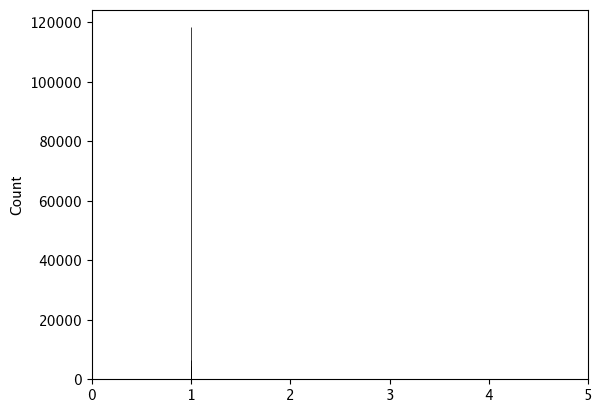

iter 5000: loss = 0.09485429
iter 5000: loss = 0.06353927
iter 5000: forward loss =  [0.041770747085726506, 0.042199354618787766, 0.042386993765830994, 0.042837873101234436, 0.04415928199887276, 0.0454956479370594, 0.04693889617919922]
iter 5000: backward loss =  [0.043537045637789366, 0.05153518542647362, 0.05226365104317665, 0.05187828838825226, 0.051098454743623734, 0.058520227670669556, 0.04935838282108307]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.42775206253715287, 0.19424335623424815, 0.37829536722338497, 0.5839794868857773, 0.4421463401331985, 0.0, 0.20138078343903554]
sigmas kde= [tensor(0.0932, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1529, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1682, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1271, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2191, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6720, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2006, dtype=to

 52%|█████▏    | 5201/10001 [3:05:50<25:08:05, 18.85s/it]  

iter 5200: loss = 0.09720987
iter 5200: loss = 0.06332588
iter 5200: forward loss =  [0.04177817895936782, 0.04242010787129402, 0.04281098395586014, 0.04323735460639, 0.04424024373292923, 0.04577788710594177, 0.047336094081401825]
iter 5200: backward loss =  [0.043095407250526865, 0.052849847823381424, 0.05363644286990166, 0.05398623272776604, 0.052139509469270706, 0.06754501909017563, 0.049615804105997086]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.43766547577277576, 0.2175623517320557, 0.398800707094773, 0.6385660097589911, 0.4852839433881891, 0.0, 0.06379248967851558]
sigmas kde= [tensor(0.0923, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1461, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1634, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1165, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1976, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5944, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2640, dtype=torch.flo

 54%|█████▍    | 5401/10001 [3:10:39<23:56:04, 18.73s/it]

iter 5400: loss = 0.09747529
iter 5400: loss = 0.06410660
iter 5400: forward loss =  [0.04282159235259844, 0.04316530004143715, 0.043498098850250244, 0.04415826126933098, 0.045140884816646576, 0.04682441055774689, 0.04813811182975769]
iter 5400: backward loss =  [0.04257002434427835, 0.051826391369104385, 0.053066544234752655, 0.05389411002397537, 0.05212745815515518, 0.06478331238031387, 0.050312500447034836]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4286640301125079, 0.21965047491503326, 0.3960168678163138, 0.6223838296132768, 0.45596816611161944, 0.0, 0.08925735170029969]
sigmas kde= [tensor(0.0944, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1457, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1613, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1194, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2089, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6598, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2514, dtype=torc

 56%|█████▌    | 5601/10001 [3:15:36<22:35:49, 18.49s/it]

iter 5600: loss = 0.09633094
iter 5600: loss = 0.06404125
iter 5600: forward loss =  [0.042201670111830666, 0.04304739460349083, 0.04332467168569565, 0.04374152421951294, 0.04470841586589813, 0.046306025236845016, 0.04741218686103821]
iter 5600: backward loss =  [0.0436791596657156, 0.05344834923744202, 0.05335903912782669, 0.05305613577365875, 0.05433161184191704, 0.056104205548763275, 0.049596156924963]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.44643530399063747, 0.21098467577952193, 0.3870801498999031, 0.6052244935864833, 0.45522124085303833, 0.0, 0.0]
sigmas kde= [tensor(0.0909, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1481, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1661, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1222, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2112, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6252, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.3325, dtype=torch.float64, grad_fn=<

 58%|█████▊    | 5801/10001 [3:20:13<22:48:06, 19.54s/it]

iter 5800: loss = 0.09309185
iter 5800: loss = 0.06184949
iter 5800: forward loss =  [0.04111686969205506, 0.04194636270403862, 0.04219987615942955, 0.04277866333723068, 0.04387534782290459, 0.04492892697453499, 0.04662767052650452]
iter 5800: backward loss =  [0.04146524038652441, 0.050581689924001694, 0.050577402114868164, 0.05104794353246689, 0.05276691913604736, 0.05385099723935127, 0.04787905886769295]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4522735730251466, 0.21645013268902283, 0.39253572499086503, 0.6302522524665698, 0.45823174940921796, 0.0, 0.13132967530569672]
sigmas kde= [tensor(0.0887, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1464, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1678, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1192, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2082, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6372, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2356, dtype=torch.

 60%|█████▉    | 6000/10001 [3:23:51<1:09:45,  1.05s/it] 

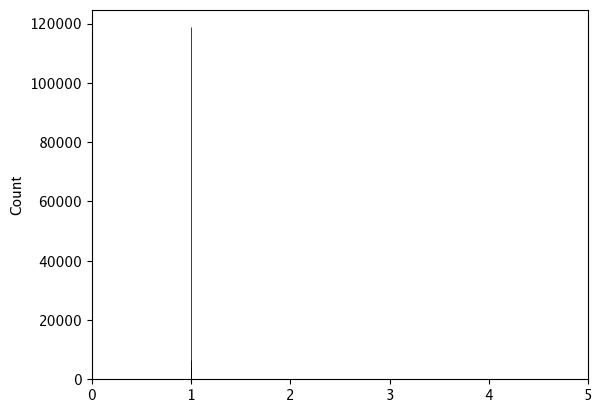

iter 6000: loss = 0.09929870
iter 6000: loss = 0.06664132
iter 6000: forward loss =  [0.04384130714493207, 0.04485507309436798, 0.044992800801992416, 0.04548650234937668, 0.04633592441678047, 0.047722335904836655, 0.0493057519197464]
iter 6000: backward loss =  [0.04560003487736317, 0.0543605238199234, 0.054881732910871506, 0.05446162074804306, 0.054962608963251114, 0.056663960218429565, 0.05162069946527481]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.43342593534668034, 0.21507267339169997, 0.3995982969394953, 0.6337012617362994, 0.4803204134804278, 0.0, 0.0]
sigmas kde= [tensor(0.0930, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1469, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1624, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1192, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2063, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5908, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2966, dtype=torch.float64, grad_fn

 62%|██████▏   | 6201/10001 [3:39:07<17:59:19, 17.04s/it]  

iter 6200: loss = 0.09368026
iter 6200: loss = 0.06295565
iter 6200: forward loss =  [0.041926854822768034, 0.04271671548485756, 0.04282907024025917, 0.043162014335393906, 0.044133514165878296, 0.04550693929195404, 0.04663507267832756]
iter 6200: backward loss =  [0.04205758301720816, 0.051497556269168854, 0.051602140069007874, 0.05090918019413948, 0.04972531646490097, 0.05558786913752556, 0.047472018748521805]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.452744530196039, 0.226775954013828, 0.3979118675065632, 0.6285217993489344, 0.4936297291723425, 0.0, 0.016504419722006114]
sigmas kde= [tensor(0.0894, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1445, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1646, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1179, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1925, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5282, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2887, dtype=torch.

 64%|██████▍   | 6401/10001 [3:43:33<16:48:49, 16.81s/it]

iter 6400: loss = 0.09480952
iter 6400: loss = 0.06215474
iter 6400: forward loss =  [0.04068574268682145, 0.04186695069074631, 0.04212157800793648, 0.04251719266176224, 0.04347265884280205, 0.04501830041408539, 0.046157658100128174]
iter 6400: backward loss =  [0.04293799977934214, 0.0531436949968338, 0.053828541189432144, 0.05282393842935562, 0.05257529392838478, 0.05755103752017021, 0.04896608367562294]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4443980825009905, 0.22552136243648563, 0.39783185340999316, 0.6271019783197984, 0.4839312512968057, 0.0, 0.2209743903542195]
sigmas kde= [tensor(0.0911, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1442, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1623, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1178, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2056, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5955, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1984, dtype=torch.flo

 66%|██████▌   | 6601/10001 [3:47:59<16:02:39, 16.99s/it]

iter 6600: loss = 0.09492507
iter 6600: loss = 0.06190707
iter 6600: forward loss =  [0.04115205605824532, 0.04195995256304741, 0.04225433990359306, 0.04262002930045128, 0.04365825653076172, 0.04510609060525894, 0.04658561944961548]
iter 6600: backward loss =  [0.04151003027842514, 0.051300786435604095, 0.05217878147959709, 0.05201691761612892, 0.053270407021045685, 0.06325580179691315, 0.04760640487074852]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.45895511117361737, 0.23439013226825242, 0.4083522621983377, 0.6426939455278874, 0.4875480281273091, 0.0, 0.179421608870448]
sigmas kde= [tensor(0.0882, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1418, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1635, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1156, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1925, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5431, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2086, dtype=torch.flo

 68%|██████▊   | 6801/10001 [3:52:25<15:06:01, 16.99s/it]

iter 6800: loss = 0.09631592
iter 6800: loss = 0.06158598
iter 6800: forward loss =  [0.04122112121071371, 0.04209333658218384, 0.042265649884939194, 0.043029338121414185, 0.043960217386484146, 0.04539182409644127, 0.04686981067061424]
iter 6800: backward loss =  [0.040729713619723815, 0.05072353407740593, 0.051935601979494095, 0.0518382303416729, 0.052559588104486465, 0.07367749512195587, 0.047915976494550705]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4507659789160085, 0.22749333661426313, 0.4038533336033266, 0.6319608002745591, 0.48602154483176613, 0.0, 0.2152141467772246]
sigmas kde= [tensor(0.0909, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1435, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1584, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1193, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2004, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5314, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2010, dtype=torc

 70%|██████▉   | 7000/10001 [3:56:32<57:25,  1.15s/it]   

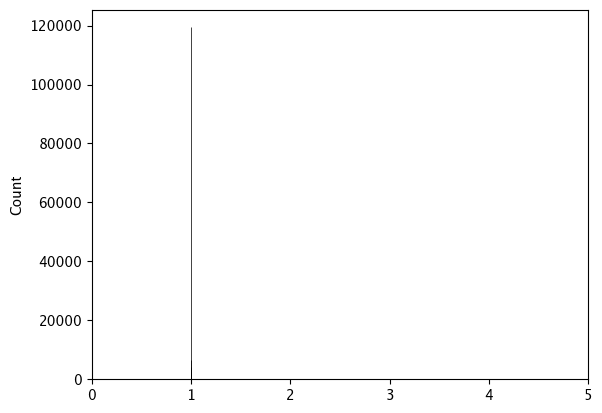

iter 7000: loss = 0.09460231
iter 7000: loss = 0.06239147
iter 7000: forward loss =  [0.040855696735198566, 0.04131590947508812, 0.041781309992074966, 0.042343758046627045, 0.04327913746237755, 0.04458707571029663, 0.04595654085278511]
iter 7000: backward loss =  [0.043071549390248084, 0.05239744484424591, 0.053068384528160095, 0.05308951437473297, 0.05245988070964813, 0.058363206684589386, 0.049646783620119095]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.44198095365080214, 0.21733196536756927, 0.38798511311188894, 0.6179670980807096, 0.4471143489442348, 0.0, 0.21206517443803075]
sigmas kde= [tensor(0.0913, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1464, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1657, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1220, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2103, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6238, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1928, dtype=t

 72%|███████▏  | 7201/10001 [4:13:52<13:49:31, 17.78s/it]  

iter 7200: loss = 0.09815605
iter 7200: loss = 0.06520985
iter 7200: forward loss =  [0.042843812644288534, 0.0436403863132, 0.04384266957640648, 0.0442192405462265, 0.04543361812829971, 0.04652906209230423, 0.047944873571395874]
iter 7200: backward loss =  [0.04473206598477922, 0.05417630821466446, 0.05503600463271141, 0.054777469485998154, 0.05595855787396431, 0.057112064212560654, 0.05084623023867607]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4587397592519225, 0.22862457658077306, 0.4004616253141319, 0.6298079224394336, 0.45750918407294705, 0.0, 0.1507714369621853]
sigmas kde= [tensor(0.0888, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1439, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1601, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1188, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2074, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6060, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2204, dtype=torch.float

 74%|███████▍  | 7401/10001 [4:18:41<14:18:34, 19.81s/it]

iter 7400: loss = 0.09545494
iter 7400: loss = 0.06433852
iter 7400: forward loss =  [0.04273148948175391, 0.04319684952497482, 0.04349139332771301, 0.04373942315578461, 0.04463573545217514, 0.04606202617287636, 0.04740419238805771]
iter 7400: backward loss =  [0.04321407023853746, 0.05244152247905731, 0.05322055518627167, 0.052308544516563416, 0.05224517732858658, 0.054422833025455475, 0.04907073453068733]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.46197757645478066, 0.23101944141558245, 0.4029115066142548, 0.6394895782790793, 0.5056581110821005, 0.0, 0.20292465414842142]
sigmas kde= [tensor(0.0872, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1430, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1611, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1175, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1944, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6425, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2067, dtype=torch.f

 76%|███████▌  | 7601/10001 [4:23:28<11:55:57, 17.90s/it]

iter 7600: loss = 0.09677174
iter 7600: loss = 0.06441401
iter 7600: forward loss =  [0.04302744754134265, 0.04358363524079323, 0.04389038309454918, 0.044271618127822876, 0.04520523175597191, 0.0466131754219532, 0.04868558049201965]
iter 7600: backward loss =  [0.04277312460683439, 0.05205395817756653, 0.05360212177038193, 0.05424002185463905, 0.05303573235869408, 0.05623764917254448, 0.05018249526619911]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.45448034904227014, 0.23341610255040526, 0.39580902160354015, 0.6230118828630538, 0.45886101936841645, 0.0, 0.22912330274785264]
sigmas kde= [tensor(0.0890, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1419, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1653, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1202, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2114, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5331, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1895, dtype=torch.f

 78%|███████▊  | 7801/10001 [4:28:13<11:05:43, 18.16s/it]

iter 7800: loss = 0.09730044
iter 7800: loss = 0.06458255
iter 7800: forward loss =  [0.04220146735019445, 0.04320323467254639, 0.043607115745544434, 0.044089965522289276, 0.045092225074768066, 0.04644779488444328, 0.047792546451091766]
iter 7800: backward loss =  [0.04476216463737577, 0.05404556170105934, 0.05487995594739914, 0.054377369582653046, 0.05412418767809868, 0.05540233105421066, 0.051077134907245636]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4412430371493843, 0.22164008098661944, 0.4011715730746048, 0.6359384447662743, 0.49648936450499875, 0.0, 0.0]
sigmas kde= [tensor(0.0921, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1448, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1598, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1169, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1988, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5943, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.3277, dtype=torch.float64, grad

 80%|███████▉  | 8000/10001 [4:32:07<36:25,  1.09s/it]   

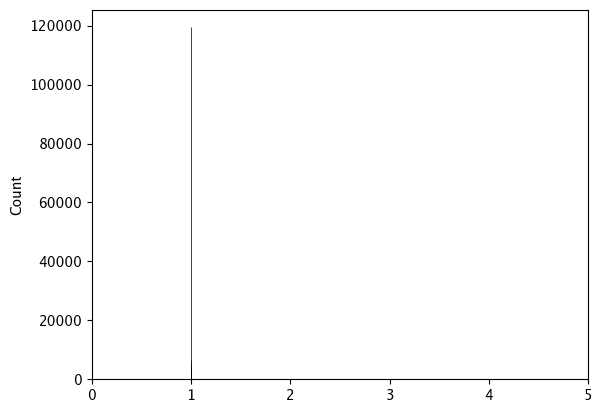

iter 8000: loss = 0.09542830
iter 8000: loss = 0.06261278
iter 8000: forward loss =  [0.04198971780583008, 0.0432208813726902, 0.043496400117874146, 0.04378363862633705, 0.04494297876954079, 0.04652346298098564, 0.04807198420166969]
iter 8000: backward loss =  [0.04124612793767499, 0.051498670130968094, 0.05166580155491829, 0.05205056443810463, 0.05167730897665024, 0.05998542532324791, 0.047845155000686646]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.45857588861614035, 0.23049799789888545, 0.4050161199793175, 0.6260122196811676, 0.4773011279448986, 0.0, 0.10992191928751027]
sigmas kde= [tensor(0.0890, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1434, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1645, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1191, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1982, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6363, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2411, dtype=torch.f

 82%|████████▏ | 8201/10001 [4:49:34<9:46:51, 19.56s/it]   

iter 8200: loss = 0.09684993
iter 8200: loss = 0.06278758
iter 8200: forward loss =  [0.041662217396104345, 0.04258674383163452, 0.0428454764187336, 0.043312788009643555, 0.04435261711478233, 0.04596846550703049, 0.04723893851041794]
iter 8200: backward loss =  [0.042250716811917034, 0.05208311975002289, 0.052129462361335754, 0.05196329578757286, 0.05248267948627472, 0.0708175003528595, 0.04825551435351372]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.45123802624187814, 0.21951929656624825, 0.4005596025587209, 0.6413810842064971, 0.4754627863702937, 0.0, 0.0]
sigmas kde= [tensor(0.0899, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1457, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1661, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1163, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2065, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5517, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.3672, dtype=torch.float64, grad_fn=

 84%|████████▍ | 8401/10001 [4:54:17<8:30:35, 19.15s/it]

iter 8400: loss = 0.10736482
iter 8400: loss = 0.06512073
iter 8400: forward loss =  [0.04281330649141344, 0.04354744404554367, 0.04376906156539917, 0.04425998404622078, 0.04513132944703102, 0.047069087624549866, 0.048380009829998016]
iter 8400: backward loss =  [0.04461484834086022, 0.05405964329838753, 0.05580255016684532, 0.05537206307053566, 0.05606450140476227, 0.11916930973529816, 0.0515005849301815]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.44510369302752967, 0.22176937635251132, 0.3703003087838476, 0.6141640095992769, 0.4641901419657496, 0.0, 0.0]
sigmas kde= [tensor(0.0915, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1445, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2220, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1202, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2034, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6247, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.4423, dtype=torch.float64, grad_fn=<

 86%|████████▌ | 8601/10001 [4:59:26<7:52:44, 20.26s/it]

iter 8600: loss = 0.09474758
iter 8600: loss = 0.06308875
iter 8600: forward loss =  [0.04219262099160758, 0.04310065880417824, 0.04329138249158859, 0.04380195587873459, 0.04453040659427643, 0.04580385237932205, 0.04749592766165733]
iter 8600: backward loss =  [0.04179225697025238, 0.05171738192439079, 0.05187387019395828, 0.05234072357416153, 0.051965516060590744, 0.05468256026506424, 0.048643920570611954]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.460948264680455, 0.2411789224514788, 0.41447798302964795, 0.6502812740776083, 0.5100062102876466, 0.0, 0.31686691215741325]
sigmas kde= [tensor(0.0892, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1410, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1571, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1138, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1901, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5716, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1651, dtype=torch.flo

 88%|████████▊ | 8801/10001 [5:04:21<6:37:38, 19.88s/it]

iter 8800: loss = 0.09927390
iter 8800: loss = 0.06429517
iter 8800: forward loss =  [0.04264003604508259, 0.043840426951646805, 0.0441889725625515, 0.04469523951411247, 0.04585777968168259, 0.04751340672373772, 0.04902118071913719]
iter 8800: backward loss =  [0.043310259535778356, 0.05321716144680977, 0.053841568529605865, 0.05287551507353783, 0.0524069108068943, 0.0714171901345253, 0.050091661512851715]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.4599980926405347, 0.23903594541439677, 0.4019326474966882, 0.6296736258107588, 0.4938785488605798, 0.0, 0.1279129045948919]
sigmas kde= [tensor(0.0883, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1408, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1699, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1176, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1985, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6256, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2312, dtype=torch.floa

 90%|████████▉ | 9000/10001 [5:08:12<21:10,  1.27s/it]  

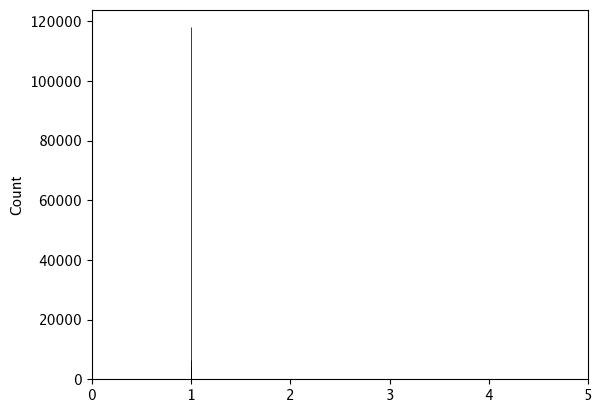

iter 9000: loss = 0.09782429
iter 9000: loss = 0.06321945
iter 9000: forward loss =  [0.04195361178494121, 0.042798321694135666, 0.043186236172914505, 0.043853119015693665, 0.04471857473254204, 0.0462963692843914, 0.04717931151390076]
iter 9000: backward loss =  [0.042531683702837206, 0.052442532032728195, 0.053199075162410736, 0.052607133984565735, 0.054202090948820114, 0.07038307189941406, 0.04941887781023979]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.45436770325305126, 0.22213401442166136, 0.3994758250507117, 0.6396414129609578, 0.48414597265235176, 0.0, 0.23545743167414124]
sigmas kde= [tensor(0.0882, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1446, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1602, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1174, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2053, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.6197, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1881, dtype=t

 92%|█████████▏| 9201/10001 [5:24:33<4:02:41, 18.20s/it]  

iter 9200: loss = 0.09630908
iter 9200: loss = 0.06329236
iter 9200: forward loss =  [0.04224562262813162, 0.042801111936569214, 0.04314737021923065, 0.043761394917964935, 0.044980473816394806, 0.04650562256574631, 0.048093270510435104]
iter 9200: backward loss =  [0.042093479430772886, 0.05264737457036972, 0.053859058767557144, 0.05284854397177696, 0.05317371338605881, 0.058484625071287155, 0.04952186346054077]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.45648482840295107, 0.22857054991571957, 0.40740223725160424, 0.6298656257172702, 0.4829827600959805, 0.0, 0.17639015324826435]
sigmas kde= [tensor(0.0886, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1433, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1586, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1183, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1974, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5191, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2113, dtype=t

 94%|█████████▍| 9401/10001 [5:29:37<3:39:40, 21.97s/it]

iter 9400: loss = 0.09358814
iter 9400: loss = 0.06157471
iter 9400: forward loss =  [0.04084495536827726, 0.041951537132263184, 0.04217180982232094, 0.042759403586387634, 0.043851908296346664, 0.04518362507224083, 0.04657818004488945]
iter 9400: backward loss =  [0.04145950926516052, 0.05114758759737015, 0.05160631984472275, 0.051087845116853714, 0.05118275061249733, 0.05695810914039612, 0.04833344742655754]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.46391432943339167, 0.23710083925567974, 0.4148841911544767, 0.649585220405721, 0.4794972838991252, 0.0, 0.04895853451388266]
sigmas kde= [tensor(0.0876, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1410, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1616, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1159, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2053, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5954, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2627, dtype=torch.

 96%|█████████▌| 9601/10001 [5:34:49<2:19:16, 20.89s/it]

iter 9600: loss = 0.14730909
iter 9600: loss = 0.06465250
iter 9600: forward loss =  [0.04289107164246452, 0.043957702815532684, 0.0443451888859272, 0.04485956206917763, 0.045801032334566116, 0.04729359596967697, 0.04874337092041969]
iter 9600: backward loss =  [0.04352285848563071, 0.05343322828412056, 0.05303530395030975, 0.052718136459589005, 0.052842769771814346, 0.40730610489845276, 0.05041372403502464]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.46861559102330913, 0.24083373377678075, 0.41516671785529147, 0.6448174846361887, 0.4851080634332029, 0.0, 0.06989619477470288]
sigmas kde= [tensor(0.0872, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1407, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1586, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1139, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2072, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.4779, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2563, dtype=torch

 98%|█████████▊| 9801/10001 [5:40:49<1:20:47, 24.24s/it]

iter 9800: loss = 0.09481558
iter 9800: loss = 0.06341291
iter 9800: forward loss =  [0.042069339815345226, 0.0431084930896759, 0.043415602296590805, 0.043798673897981644, 0.04474267736077309, 0.04620414972305298, 0.04751250520348549]
iter 9800: backward loss =  [0.04268713748405691, 0.05169179290533066, 0.052140817046165466, 0.05161132663488388, 0.05151238292455673, 0.05436120927333832, 0.04885292425751686]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.43829565065779313, 0.2167484135652592, 0.3847814662905783, 0.6204722482473114, 0.45562491699550467, 0.0, 0.20871723953762522]
sigmas kde= [tensor(0.0928, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1461, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1638, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1200, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2108, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.5857, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1902, dtype=torch.

100%|█████████▉| 10000/10001 [5:45:11<00:01,  1.22s/it] 

iter 10000: loss = 0.09559026
iter 10000: loss = 0.06207716
iter 10000: forward loss =  [0.040676539566422136, 0.041930027306079865, 0.04234127327799797, 0.042683959007263184, 0.04398718103766441, 0.04582858830690384, 0.04774156212806702]
iter 10000: backward loss =  [0.04280124594184776, 0.052266135811805725, 0.05251436308026314, 0.05166841298341751, 0.05587168037891388, 0.05841844901442528, 0.050402380526065826]
scales: [116, 58, 29, 14, 7, 3, 1]
dEIs kde =  [0.45571779538363527, 0.23140128208824556, 0.4052263446906497, 0.6368435912674305, 0.4980462903576712, 0.0, 0.0]
sigmas kde= [tensor(0.0900, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1426, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1627, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1179, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1996, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.4673, dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.2921, dtype=torch.float64, g

100%|██████████| 10001/10001 [5:46:21<00:00,  2.08s/it]


In [9]:
#NIS plus
EIs,CEs,LOSSes=train_and_memorize(f_imgs_norm_train,'AOMIC_preprocessed','aal',epoches=10001,hidden_units = 256,scale=1,batch_size =100,version=1,use_cuda_f=use_cuda)

In [10]:
#arraylize all tensors and save 
loss_array=np.array([LOSSes[i].item() for i in range(len(LOSSes))])
np.save('AOMIC_preprocessed_Results/Losses_kde.npy',loss_array)
EIs_array=np.array(EIs)
np.save('AOMIC_preprocessed_Results/EIs_kde.npy',EIs_array)
CEs_array=np.array(CEs)
np.save('AOMIC_preprocessed_Results/CEs_kde.npy',CEs_array)
#Load all of these data and draw Visulize plots
loss_array=np.load('AOMIC_preprocessed_Results/Losses_kde.npy')
EIs_array=np.load('AOMIC_preprocessed_Results/EIs_kde.npy')
CEs_array=np.load('AOMIC_preprocessed_Results/CEs_kde.npy')

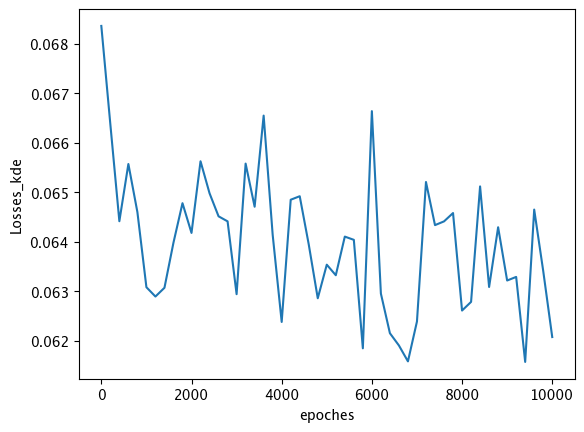

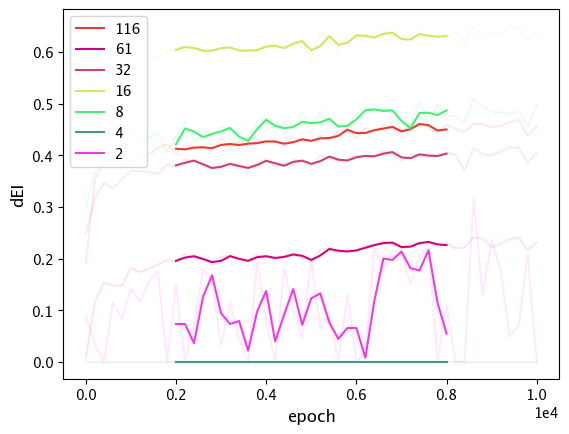

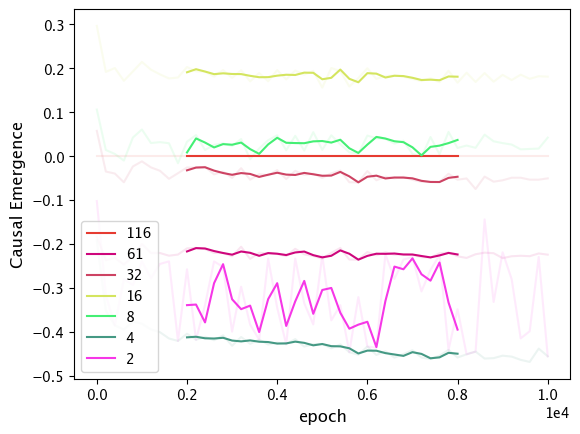

In [11]:
read_and_visulize(EIs_array,CEs_array,loss_array,dim=f_imgs_norm.shape[2],path_name="AOMIC_preprocessed_Results",method='aal',version=1)